# Priprema podataka
Ovaj deo je isti kao u svesci modelovanje

In [239]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import model_selection 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [117]:
data = pd.read_csv('brca_metabric/Final_Data.tsv', sep='\t')

In [118]:
LYMPH_dummy = pd.get_dummies(data['LYMPH_NODES_EXAMINED_POSITIVE'], prefix='LYMPH', drop_first=True)
CELLULARITY_dummy = pd.get_dummies(data['CELLULARITY'], prefix='CELLULARITY', drop_first=True)
ER_dummy = pd.get_dummies(data['ER_IHC'], prefix='ER_IHC', drop_first=True)
HER2SNP_dummy = pd.get_dummies(data['HER2_SNP6'], prefix='HER2_SNP6', drop_first=True)
HER_dummy = pd.get_dummies(data['HER2_STATUS'], prefix='HER2_STATUS', drop_first=True)
PR_dummy = pd.get_dummies(data['PR_STATUS'], prefix='PR_STATUS', drop_first=True)
INTCLUS_dummy = pd.get_dummies(data['INTCLUST'], prefix='INTCLUST', drop_first=True)
GRADE_dummy = pd.get_dummies(data['GRADE'], prefix='GRADE', drop_first=True)

In [189]:
df = pd.concat([LYMPH_dummy, CELLULARITY_dummy, ER_dummy,  HER_dummy,
                PR_dummy, INTCLUS_dummy, GRADE_dummy], axis = 1)
y = data[['CLAUDIN_SUBTYPE']]

# Random Forest

Savet je bio da se razdvoje kategorički atributi, pa da se odradi standardizacija nad nekategoričkim atributima i konačno da se oba skupa spoje. Međutim, jedini nekategorički atribut je bio 'NPI', a za njega smo utvrdili u prošlom listu da svojim prisustvom smanjuje tačnost predikcije. Zbog toga je taj atribut uklonjen, tako da standardizacija ne može ni biti odrađena.

In [256]:
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df, y, test_size=0.1, random_state=1, shuffle=True, stratify=y)

In [188]:
# scaler = StandardScaler()
# scaler.fit(xtrain_nc)
# xtrain_sc = scaler.transform(xtrain_nc)
# xtest_sc = scaler.transform(xtest_nc)

Iskoristićemo unakrsnu validaciju GirdSearchCV iz paketa model_selection, kako bismo odredili najbolje kombinacije parametara.

In [232]:
grid_model = RandomForestClassifier()
params = {
    'random_state' : [0, 1, 5, 7],
    'n_estimators': [200, 400, 600, 800], 
    'criterion': ["gini", "entropy"]
}
grid = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='accuracy',  return_train_score=True)


In [233]:
grid.fit(xtrain, ytrain)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [200, 400, 600, 800], 'random_state': [0, 1, 5, 7], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [235]:
grid.best_score_

0.5692567567567568

In [236]:
grid.best_params_

{'criterion': 'entropy', 'n_estimators': 800, 'random_state': 7}

Zatim ćemo nad najboljom kombinacijom parametara definisati model i primeniti ga na podatke:

In [257]:
rf_classifier = RandomForestClassifier(random_state=7, n_estimators=800, criterion='entropy')
rf_classifier.fit(xtrain, ytrain)
rf_predictions = rf_classifier.predict(xtest)
print(classification_report(ytest, rf_predictions))

/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

       Basal       0.82      0.67      0.74        21
        Her2       0.74      0.64      0.68        22
        LumA       0.68      0.87      0.76        70
        LumB       0.66      0.60      0.63        48
      Normal       0.40      0.13      0.20        15
 claudin-low       0.48      0.50      0.49        22

   micro avg       0.66      0.66      0.66       198
   macro avg       0.63      0.57      0.58       198
weighted avg       0.65      0.66      0.65       198



Izračunaćemo matricu konfuzije i grafički je prikazati:

In [258]:
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(ytest, rf_predictions)
np.set_printoptions(precision=2)
print(cnf_matrix)

[[14  1  1  0  1  4]
 [ 0 14  0  6  1  1]
 [ 0  0 61  7  0  2]
 [ 0  2 17 29  0  0]
 [ 0  2  5  1  2  5]
 [ 3  0  6  1  1 11]]


In [173]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[14  1  1  0  1  4]
 [ 0 14  0  6  1  1]
 [ 0  0 61  7  0  2]
 [ 0  2 17 29  0  0]
 [ 0  2  5  1  2  5]
 [ 3  0  6  1  1 11]]


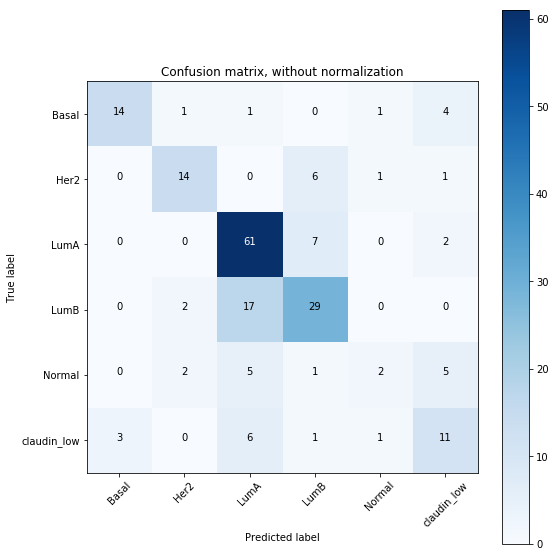

In [259]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['Basal', 'Her2', 'LumA', 'LumB', 'Normal', 'claudin_low'],
                      title='Confusion matrix, without normalization')



plt.show()

Ideja je bila da se prikaže i normalizovana matrica jer daje mnogo jasniju sliku, ali su brojevi u decimalnom zapisu ispisani sa prevelikim brojem decimala, iako sam podesila parametre za preciznost zapisa. (Otkomentarisati za rezultat)

In [261]:
#Plot normalized confusion matrix
# plt.figure(figsize=(8, 8))
# np.set_printoptions(precision=2)
# plot_confusion_matrix(cnf_matrix, classes=['Basal', 'Her2', 'LumA', 'LumB', 'Normal', 'claudin_low'], normalize=True,
#                       title='Normalized confusion matrix')
# plt.show()

# SVC

Sada ćemo isti postupak ponoviti sa SVC modelom, jer je i on korišćen u prethodnoj svesci.

In [240]:
grid_model = svm.SVC()
params = {
    'C': [10**i for i in range(-5, 5)], 
    'gamma': [10**i for i in range(-3, 3)]
}
grid = model_selection.GridSearchCV(grid_model, param_grid=params, scoring='accuracy', cv=10, return_train_score=True)

In [241]:
grid.fit(xtrain, ytrain)

/home/naca/anaconda3/lib/python2.7/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [243]:
grid.best_score_

0.5912162162162162

In [244]:
grid.best_params_

{'C': 10, 'gamma': 0.1}

In [245]:
svm_classifier = svm.SVC(C=10, gamma=0.1)
svm_classifier.fit(xtrain, ytrain)
svm_predictions = svm_classifier.predict(xtest)
print(classification_report(ytest, svm_predictions))

              precision    recall  f1-score   support

       Basal       0.74      0.81      0.77        21
        Her2       0.61      0.50      0.55        22
        LumA       0.63      0.90      0.74        70
        LumB       0.63      0.46      0.53        48
      Normal       0.40      0.13      0.20        15
 claudin-low       0.53      0.41      0.46        22

   micro avg       0.63      0.63      0.63       198
   macro avg       0.59      0.54      0.54       198
weighted avg       0.61      0.63      0.60       198



In [246]:
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(ytest, rf_predictions)
np.set_printoptions(precision=2)
print(cnf_matrix)

[[14  1  1  0  1  4]
 [ 0 14  0  6  1  1]
 [ 0  0 61  7  0  2]
 [ 0  2 17 29  0  0]
 [ 0  2  5  1  2  5]
 [ 3  0  6  1  1 11]]


Confusion matrix, without normalization
[[14  1  1  0  1  4]
 [ 0 14  0  6  1  1]
 [ 0  0 61  7  0  2]
 [ 0  2 17 29  0  0]
 [ 0  2  5  1  2  5]
 [ 3  0  6  1  1 11]]


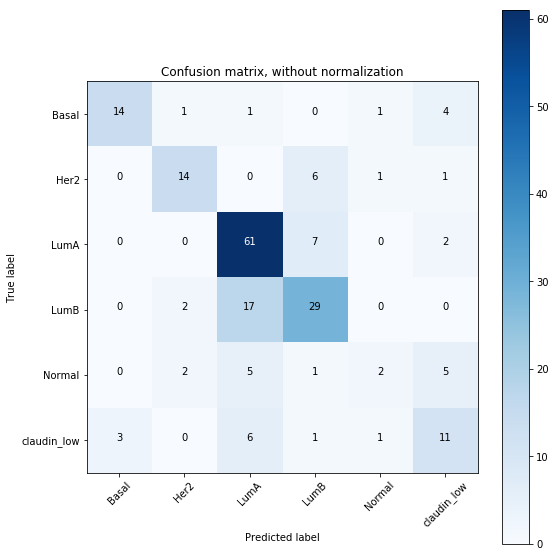

In [247]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['Basal', 'Her2', 'LumA', 'LumB', 'Normal', 'claudin_low'],
                      title='Confusion matrix, without normalization')



plt.show()